In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch.optim as optim
from numpy import vstack
%matplotlib inline
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import pickle
import os
import timeit
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
# GAN - Discriminator
class Discriminator(nn.Module):
    def __init__(self,input_dim):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2,1),
            nn.Sigmoid()

        )
    def forward(self,x):
        return self.layer(x)    

In [3]:
# GAN-G Adversarial Attack 2

class Generator(nn.Module):
    def __init__(self,input_dim):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(True),
             nn.Linear(input_dim//2, input_dim),
             nn.Sigmoid()
   
        )
    def forward(self, z):
         return self.layer(z)
        
        
def gen_adversarial_attack(generator_out, raw_attack, attack_category,POS_NONFUNCTIONAL_FEATURES):
    pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES[attack_category]
    # Keep the functional features
    adversarial_attack = raw_attack.clone().type(th.FloatTensor)
#     adversarial_attack = raw_attack.detach()
    for row_idx in range(len(adversarial_attack)):
        adversarial_attack[row_idx][pos_nonfunctional_feature] = generator_out[row_idx]
    return adversarial_attack

In [4]:
# cal_dr 
def cal_dr(ids_model, normal, raw_attack, adversarial_attack):
    # Make data to feed IDS contain: Attack & Normal
    o_ids_input = th.cat((raw_attack, normal))
    a_ids_input = th.cat((adversarial_attack,normal))
    # Shuffle Input
    l = list(range(len(a_ids_input)))
    np.random.shuffle(l)
    o_ids_input = o_ids_input[l]
    a_ids_input = a_ids_input[l]
    # IDS Predict Label
    o_pred_label = th.Tensor(ids_model.predict(o_ids_input))
    a_pred_label = th.Tensor(ids_model.predict(a_ids_input))
    # True Label
    ids_true_label = np.r_[np.ones(batch),np.zeros(batch)][l]
    
    # Calc DR
    tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,o_pred_label).ravel()
    tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,a_pred_label).ravel()
    
    
#     Calculte True Negative Rate for adversarial data
    a_tnr = (tn2/batch)*100
    origin_dr = tp1/(tp1 + fp1)
    adversarial_dr = tp2/(tp2 + fp2)
    o_f1_score =  f1_score(ids_true_label, o_pred_label)
    a_f1_score =  f1_score(ids_true_label, a_pred_label)
    o_recall=  recall_score(ids_true_label, o_pred_label)
    a_recall =  recall_score(ids_true_label, a_pred_label)
    
    return origin_dr, adversarial_dr,o_f1_score,a_f1_score,o_recall,a_recall,a_tnr

In [104]:
data = pd.read_csv('GAN_train_2.csv')

In [105]:
attack_data = data[data['Label'] == 1]
benign_data = data[data['Label'] == 0]
attack_labels = data[data['Label'] == 1]['Label']
benign_labels = data[data['Label'] == 0]['Label']
attack_data = attack_data.drop('Label',axis=1)
ad_columns = attack_data.columns
benign_data = benign_data.drop('Label',axis=1)

# Convert  to torch tensor.
attack_data = th.from_numpy(attack_data.to_numpy()).type(th.float)

attack_labels = th.from_numpy(attack_labels.to_numpy()).type(th.float)
benign_data = th.from_numpy(benign_data.to_numpy()).type(th.float)
benign_labels = th.from_numpy(benign_labels.to_numpy()).type(th.float)  

# Create a tensor dataset
attack_ds = TensorDataset(attack_data,attack_labels)
benign_ds = TensorDataset(benign_data,benign_labels)



In [42]:
# load the model from disk
def load_model(filename):
 loaded_model = pickle.load(open(filename, 'rb'))
 return loaded_model

In [43]:
ids_name = 'ids_model_2.sav'

In [44]:
# Load Trained IDS Model
ids_model = load_model(ids_name)


In [45]:
# Global Variables
N_FEATURES = 41
FUN_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30]

POS_FUNCTIONAL_FEATURES = {'DDoS': FUN_FEATURES}
POS_NONFUNCTIONAL_FEATURES = {}
for attack_category, pos_functional_feature in POS_FUNCTIONAL_FEATURES.items():
    pos_nonfunctional_feature = []
    for i in range(N_FEATURES):
        if i not in pos_functional_feature:
            pos_nonfunctional_feature.append(i)
    POS_NONFUNCTIONAL_FEATURES[attack_category] = pos_nonfunctional_feature



In [11]:
IDS_INPUT_DIM = N_FEATURES
IDS_OUTPUT_DIM = 2
ATTACK_CATEGORIES = ['DDoS']
attack_category = 'DDoS'
D_OUTPUT_DIM = 1
G_INPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])
G_OUTPUT_DIM = G_INPUT_DIM
input_length = N_FEATURES

num_epochs = 100
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
CLAMP = 0.01
batch = 512


In [46]:
print('Position of Functional Features\n  ', POS_FUNCTIONAL_FEATURES)
print('Position of Non Functional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)

Position of Functional Features
   {'DDoS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30]}
Position of Non Functional Features:
   {'DDoS': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


In [126]:
generator = Generator(G_INPUT_DIM)
discriminator = Discriminator(N_FEATURES)
# Optimizers
generator_optimizer = th.optim.RMSprop(generator.parameters(), lr=0.001)
discriminator_optimizer = th.optim.RMSprop(discriminator.parameters(), lr=0.001)


In [48]:
def train_2():
   
    generator.train()
    discriminator.train()
    ad_data = np.empty([0,41])
    cnt = -5
    g_loss_vals = []
    d_loss_vals = []
    EIR_vals = []
    adversarial_dr_vals = []
    original_dr_vals = []
    a_f1_vals = []
    a_tnr_vals = []
    a_recall_vals = []
    d_loss_normal = []
    d_loss_attack = []
    labels = ['Epoch', 'G-Loss', 'D-Loss', 'O-DR(%)', 'A-DR(%)','TNR(%)','Runtime(s)']
    print("{: >10} {: >10} {: >10} {: >10} {: >10} {: >10} {: >10}".format(*labels))
    for i in range(num_epochs):
        
        run_g_loss = 0.
        run_d_loss = 0.
        run_d_loss_normal = 0.
        run_d_loss_attack = 0.
        c=0
        
        attack_dl = DataLoader(attack_ds, batch_size=batch,shuffle = True)
        benign_dl = DataLoader(benign_ds, batch_size=batch,shuffle = True)
       
        
        attack_data,attack_label = iter(attack_dl).next()
        normal_data,normal_label = iter(benign_dl).next()
        
        time_start = timeit.default_timer()
        #  Train Generator
        for p in discriminator.parameters():  
            p.requires_grad = False
         # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        noise = th.randint(0, 2, size=(len(attack_label), G_INPUT_DIM)).float()
        length = len(attack_data)

        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES['DDoS']
        nonfunctional_feature = attack_data[:, pos_nonfunctional_feature]
        
        attack_traffic = th.cat((noise,nonfunctional_feature),dim = 0)
        l = list(range(length))
        np.random.shuffle(l)
        attack_traffic = attack_traffic[l]
        generator_out = generator(attack_traffic)
        adversarial_attack = gen_adversarial_attack(generator_out, attack_data, attack_category, POS_NONFUNCTIONAL_FEATURES)
#         Store adversarial data
        adversarial_array =np.array(adversarial_attack.detach())
        ad_data = np.concatenate((ad_data, adversarial_array), axis=0)
        D_pred= discriminator(adversarial_attack)
        g_loss = -th.mean(D_pred)
        
        g_loss_vals.append(g_loss.detach())
        g_loss.backward()
        generator_optimizer.step()
        run_g_loss += g_loss.item()
        
        # Train Discreminator
        for p in discriminator.parameters(): 
            p.requires_grad = True
        
        for c in range(CRITIC_ITERS):
            discriminator_optimizer.zero_grad()
            
            for p in discriminator.parameters():
                p.data.clamp_(-CLAMP, CLAMP) 
                
            noise = th.randint(0, 2, size=(len(attack_label), G_INPUT_DIM)).float()
            length = len(attack_data)

            pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES['DDoS']
            nonfunctional_feature = attack_data[:, pos_nonfunctional_feature]
            attack_traffic = th.cat((noise,nonfunctional_feature),dim = 0)
            l = list(range(length))
            np.random.shuffle(l)
            attack_traffic = attack_traffic[l]
            generator_out = generator(attack_traffic)
            adversarial_attack = gen_adversarial_attack(generator_out, attack_data, attack_category, POS_NONFUNCTIONAL_FEATURES)
            
            ids_input = th.cat((adversarial_attack,normal_data))
            l = list(range(len(ids_input)))
            np.random.shuffle(l)
            ids_input = V(th.Tensor(ids_input[l]))
            
            ids_pred_label = V(th.Tensor(ids_model.predict(ids_input)))
            
            pred_normal = ids_input[ids_pred_label==0]
            pred_attack = ids_input[ids_pred_label==1]
           

            if len(pred_attack) == 0:
                cnt += 1
                break
            D_noraml = discriminator(V(th.Tensor(pred_normal)))
            D_attack= discriminator(V(th.Tensor(pred_attack)))
            
            loss_normal = th.mean(D_noraml)
            loss_attack = th.mean(D_attack)
            
            run_d_loss_normal += loss_normal.detach().item()
           
            run_d_loss_attack += loss_attack.detach().item()
      
            d_loss =  loss_attack - loss_normal 
#             d_loss =  loss_normal - loss_attack 
            
            d_loss.backward()
            discriminator_optimizer.step()
            run_d_loss += d_loss.detach().item()
         
        origin_dr, adversarial_dr,o_f1_score,a_f1_score,o_recall,a_recall,a_tnr= cal_dr(ids_model, normal_data, attack_data, adversarial_attack.detach())
        a_tnr_vals.append(a_tnr)
        a_f1_vals.append(a_f1_score)
        a_recall_vals.append(a_recall)
        #  Calculate evasion increase rate
        EIR = 1 - (adversarial_dr/origin_dr)
        EIR_vals.append(EIR)
        adversarial_dr_vals.append(adversarial_dr)
        original_dr_vals.append(origin_dr)
#         print('Epoch:',i,",origin_dr:",origin_dr*100,",adversarial_dr:",adversarial_dr*100)
        d_loss_vals.append(run_d_loss/CRITIC_ITERS)  
        d_loss_normal.append(run_d_loss_normal/CRITIC_ITERS)
        d_loss_attack.append(run_d_loss_attack/CRITIC_ITERS)
#         print_vals = [(i + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (origin_dr*100), (adversarial_dr*100)]
#       Calculate runtime
        runtime = timeit.default_timer() - time_start
        print_vals = [(i + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (origin_dr*100), (adversarial_dr*100),a_tnr, runtime]
        print_string = []
        for val in print_vals:
                if isinstance(val, float):
                    print_string.append(str(f"{val:.6f}"))
                else:
                    print_string.append(str(val))
        print("{: >10} {: >10} {: >10} {: >10} {: >10}{: >10}{: >10}".format(*print_string))
#     return g_loss_vals, d_loss_vals,d_loss_normal,d_loss_attack,adversarial_dr_vals,original_dr_vals,EIR_vals,ad_data,o_f1_score,a_f1_score,o_recall,a_recall 
    return g_loss_vals, d_loss_vals,d_loss_normal,d_loss_attack,adversarial_dr_vals,original_dr_vals,EIR_vals,ad_data,o_f1_score,a_f1_vals,o_recall,a_recall_vals,a_tnr_vals  

In [127]:
g_loss,d_loss,d_loss_normal,d_loss_attack,adversarial_dr_vals,original_dr_vals,EIR_vals,ad_data,o_f1_score,a_f1_score,o_recall,a_recall,a_tnr  = train_2()

     Epoch     G-Loss     D-Loss    O-DR(%)    A-DR(%)     TNR(%) Runtime(s)
         1  -0.542282  -0.013433  99.023438  98.437500 98.242188  0.493230
         2  -0.445819  -0.024039  98.437500  99.218750 97.851562  0.396972
         3  -0.459958  -0.024234  99.023438  98.632812 98.046875  0.467088
         4  -0.463915  -0.024019  97.656250 100.000000 98.242188  0.385520
         5  -0.466437  -0.024218  98.242188 100.000000 99.218750  0.418052
         6  -0.468028  -0.023695  97.460938  99.218750 99.023438  0.495736
         7  -0.469605  -0.023650  98.242188  99.414062 98.632812  0.555299
         8  -0.470475  -0.023256  98.046875  99.414062 98.828125  0.531525
         9  -0.471291  -0.023169  99.023438  98.828125 98.632812  0.400129
        10  -0.472152  -0.022445  97.851562  98.632812 98.242188  0.509530
        11  -0.473346  -0.021764  97.460938  98.828125 98.046875  0.455898
        12  -0.474117  -0.021628  98.046875  96.875000 99.023438  0.447289
        13  -0.474742  

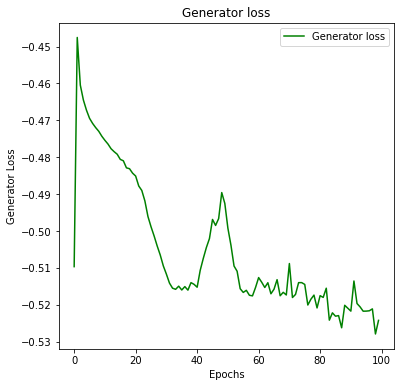

In [50]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, g_loss,color = 'g',label = 'Generator loss')
# plt.plot(epochs, d,color = 'r',label = 'Discriminator loss')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Generator Loss")
plt.title("Generator loss")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

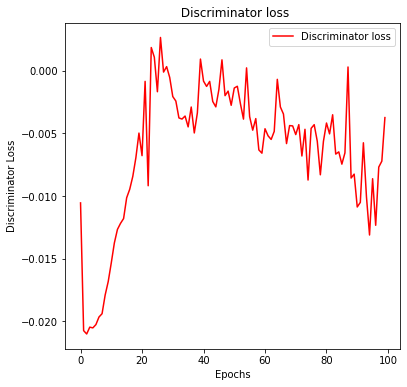

In [19]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, d_loss,color = 'r',label = 'Discriminator loss')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Discriminator Loss")
plt.title(" Discriminator loss")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

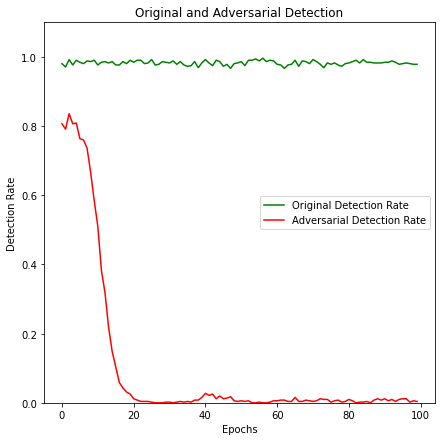

In [51]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(7,7))
plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original Detection Rate')
plt.plot(epochs, adversarial_dr_vals,color = 'r',label = 'Adversarial Detection Rate')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Detection Rate")
plt.ylim((0,1.1))
plt.title("Original and Adversarial Detection")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

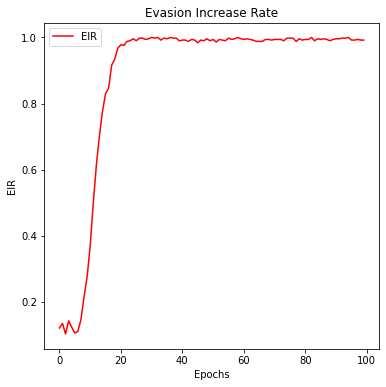

In [21]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, EIR_vals,color = 'r',label = 'EIR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("EIR")
plt.title("Evasion Increase Rate")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Save Generated adversarial data in CSV file

In [159]:
df_adv = pd.DataFrame(ad_data,columns=ad_columns)

In [160]:
df_adv.to_csv('adv_data.csv',index=False)

## GAN Model Evalution 

In [128]:
test_path = "GAN_test_2.csv"

In [129]:
test_data = pd.read_csv(test_path)

In [130]:
test_attack_data = test_data[test_data['Label'] == 1]
test_benign_data = test_data[test_data['Label'] == 0]
test_attack_labels = test_data[test_data['Label'] == 1]['Label']
test_benign_labels = test_data[test_data['Label'] == 0]['Label']
test_attack_data = test_attack_data.drop('Label',axis=1)
test_benign_data = test_benign_data.drop('Label',axis=1)


# Convert  to torch tensor.
test_attack_data = th.from_numpy(test_attack_data.to_numpy()).type(th.float)
test_attack_labels = th.from_numpy(test_attack_labels.to_numpy()).type(th.float)
test_benign_data = th.from_numpy(test_benign_data.to_numpy()).type(th.float)
test_benign_labels = th.from_numpy(test_benign_labels.to_numpy()).type(th.float)  

# Create a tensor dataset
test_attack_ds = TensorDataset(test_attack_data,test_attack_labels)
test_benign_ds = TensorDataset(test_benign_data,test_benign_labels)

In [183]:
print(len(test_data))
print('Attack Data',test_attack_data.size())
print('Benign Data',test_benign_data.size())

104712
Attack Data torch.Size([38027, 41])
Benign Data torch.Size([66685, 41])


### Create Dataframe of adversarial data and save it in csv file 

In [188]:
# adversarial_data =np.array(adversarial_attack.detach())

In [189]:
# df_adv_test = pd.DataFrame(adversarial_data,columns=ad_columns)

In [190]:
# df_adv_test.to_csv('test_adv_attacks.csv',index=False)

### Load IDS model trained with adversarial data

In [131]:
ids_ad_model_name = 'ids_ad_trained.sav'

In [132]:
ids_ad_model = load_model(ids_ad_model_name)

### Detect adversarial after training 

In [57]:
def detect_ad():
   
    test_ad_data = np.empty([0,41])
    adversarial_dr_vals = []
    original_dr_vals = []
    EIR_vals = []
    a_f1_vals = []
    a_recall_vals = []
    a_tnr_vals = []
    
    labels = ['Epoch', 'O-DR(%)', 'A-DR(%)','TNR(%)']
    print(" {: >15} {: >15} {: >15} {: >15}".format(*labels))
    for i in range(num_epochs):
        
        attack_dl = DataLoader(test_attack_ds, batch_size=504,shuffle = True)
        benign_dl = DataLoader(test_benign_ds, batch_size=504,shuffle = True)
       
        
        attack_data,attack_label = iter(attack_dl).next()
        normal_data,normal_label = iter(benign_dl).next()
        
        noise = th.randint(0, 2, size=(len(attack_label), G_INPUT_DIM)).float()
        length = len(attack_data)
        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES['DDoS']
        nonfunctional_feature = attack_data[:, pos_nonfunctional_feature]
        
        attack_traffic = th.cat((noise,nonfunctional_feature),dim = 0)
        l = list(range(length))
        np.random.shuffle(l)
        attack_traffic = attack_traffic[l]
        generator_out = generator(attack_traffic)
        adversarial_attack = gen_adversarial_attack(generator_out, attack_data, attack_category, POS_NONFUNCTIONAL_FEATURES)
       
  #    Collect adversarial test data     
        adversarial_array =np.array(adversarial_attack.detach())
        test_ad_data = np.concatenate((test_ad_data, adversarial_array), axis=0)
        
        origin_dr, adversarial_dr,o_f1_score,a_f1_score,o_recall,a_recall,a_tnr = cal_dr(ids_ad_model, normal_data, attack_data, adversarial_attack.detach())
        a_tnr_vals.append(a_tnr)
        a_f1_vals.append(a_f1_score)
        a_recall_vals.append(a_recall)
        #  Calculate evasion increase rate
        EIR = 1 - (adversarial_dr/origin_dr)
        EIR_vals.append(EIR)
        adversarial_dr_vals.append(adversarial_dr)
        original_dr_vals.append(origin_dr)

        print_vals = [(i + 1), (origin_dr*100), (adversarial_dr*100),a_tnr]
        print_string = []
        for val in print_vals:
                if isinstance(val, float):
                    print_string.append(str(f"{val:.6f}"))
                else:
                    print_string.append(str(val))
        print(" {: >15} {: >15} {: >15} {: >15}".format(*print_string))
    return adversarial_dr_vals,original_dr_vals,EIR_vals,o_f1_score,a_f1_vals,o_recall,a_recall_vals,a_tnr_vals,test_ad_data

In [133]:
ad_dr_after_training,original_dr_after_training,EIR_after_training,o_f1_score_retrained,a_f1_score_retrained,o_recall_retrained,a_recall_retrained,a_tnr_retrained,test_ad_data  = detect_ad()

           Epoch         O-DR(%)         A-DR(%)          TNR(%)
               1       98.242188       98.437500       95.312500
               2       98.046875       98.437500       95.703125
               3       98.437500       98.437500       95.312500
               4       98.242188       98.437500       94.921875
               5       98.046875       98.632812       95.312500
               6       97.851562       98.437500       94.531250
               7       98.242188       98.437500       95.312500
               8       97.265625       98.437500       95.117188
               9       98.046875       98.437500       95.507812
              10       98.242188       98.437500       95.898438
              11       98.242188       98.437500       95.117188
              12       98.046875       98.437500       96.093750
              13       97.656250       98.437500       96.289062
              14       98.046875       98.437500       96.875000
              15       98

In [125]:
epoch = 100

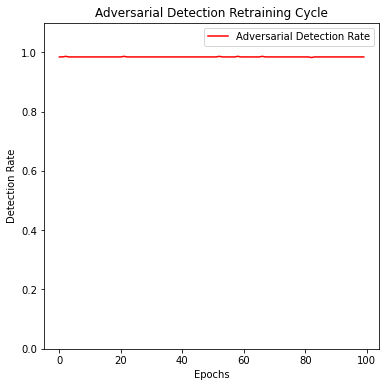

In [59]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_after_training,color = 'g',label = 'Original Detection Rate')
plt.plot(epochs, ad_dr_after_training,color = 'r',label = 'Adversarial Detection Rate')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Detection Rate")
plt.ylim(0,1.1)
# plt.title("Original and Adversarial Detection")
plt.title("Adversarial Detection Retraining Cycle")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Create Polymorphic attack data changing 5 features 

In [60]:
#  A function to change feature values for polymorphic attacks
def change_feature_values(df,indices):
    for i in indices:
        df[i] = df[i] + df[i]*5/100
    return df 

In [61]:
# Change 5 non functional features
indices = [9,10,11,12,13]


In [62]:
data_mutated_5 = change_feature_values(attack_data,indices)
mutated_5_ds = TensorDataset(data_mutated_5,attack_labels)

In [31]:
def train_poly(ids_model,ds_attack):
    
    
    # Optimizers
    generator_optimizer = th.optim.RMSprop(generator.parameters(), lr=0.001)
    discriminator_optimizer = th.optim.RMSprop(discriminator.parameters(), lr=0.001)

    generator.train()
    discriminator.train()
    cnt = -5
    g_loss_vals = []
    d_loss_vals = []
    EIR_vals = []
    adversarial_dr_vals = []
    original_dr_vals = []
    d_loss_normal = []
    d_loss_attack = []
    a_f1_vals = []
    a_recall_vals = []
    a_tnr_vals = []
    poly_ad_data = np.empty([0,41])
    labels = ['Epoch', 'G-Loss', 'D-Loss', 'O-DR(%)', 'A-DR(%)','Runtime(s)']
    print("{: >10} {: >15} {: >15} {: >15} {: >15}{: >15}".format(*labels))
    for i in range(num_epochs):
        
        run_g_loss = 0.
        run_d_loss = 0.
        run_d_loss_normal = 0.
        run_d_loss_attack = 0.
        c=0
        
        attack_dl = DataLoader(ds_attack, batch_size=batch,shuffle = True)
        benign_dl = DataLoader(benign_ds, batch_size=batch,shuffle = True)
       
        
        attack_data,attack_label = iter(attack_dl).next()
        normal_data,normal_label = iter(benign_dl).next()
        
        time_start = timeit.default_timer()
        #  Train Generator
        for p in discriminator.parameters():  
            p.requires_grad = False
         # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        noise = th.randint(0, 2, size=(len(attack_label), G_INPUT_DIM)).float()
        length = len(attack_data)

        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES['DDoS']
        nonfunctional_feature = attack_data[:, pos_nonfunctional_feature]
        
        attack_traffic = th.cat((noise,nonfunctional_feature),dim = 0)
        l = list(range(length))
        np.random.shuffle(l)
        attack_traffic = attack_traffic[l]
        generator_out = generator(attack_traffic)
        adversarial_attack = gen_adversarial_attack(generator_out, attack_data, attack_category, POS_NONFUNCTIONAL_FEATURES)
       
        adversarial_array =np.array(adversarial_attack.detach())
        poly_ad_data = np.concatenate((poly_ad_data, adversarial_array), axis=0)
        
        D_pred= discriminator(adversarial_attack)
        
        g_loss = -th.mean(D_pred)
        
        g_loss_vals.append(g_loss.detach())
        g_loss.backward()
        generator_optimizer.step()
        run_g_loss += g_loss.item()
        
        # Train Discreminator
        for p in discriminator.parameters(): 
            p.requires_grad = True
        
        for c in range(CRITIC_ITERS):
            discriminator_optimizer.zero_grad()
            
            for p in discriminator.parameters():
                p.data.clamp_(-CLAMP, CLAMP) 
                
            noise = th.randint(0, 2, size=(len(attack_label), G_INPUT_DIM)).float()
            length = len(attack_data)

            pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES['DDoS']
            nonfunctional_feature = attack_data[:, pos_nonfunctional_feature]
            attack_traffic = th.cat((noise,nonfunctional_feature),dim = 0)
            l = list(range(length))
            np.random.shuffle(l)
            attack_traffic = attack_traffic[l]
            generator_out = generator(attack_traffic)
            adversarial_attack = gen_adversarial_attack(generator_out, attack_data, attack_category, POS_NONFUNCTIONAL_FEATURES)
            
            ids_input = th.cat((adversarial_attack,normal_data))
            l = list(range(len(ids_input)))
            np.random.shuffle(l)
            ids_input = V(th.Tensor(ids_input[l]))
            
            ids_pred_label = V(th.Tensor(ids_model.predict(ids_input)))
            
            pred_normal = ids_input[ids_pred_label==0]
            pred_attack = ids_input[ids_pred_label==1]
           

            if len(pred_attack) == 0:
                cnt += 1
                break
            D_noraml = discriminator(V(th.Tensor(pred_normal)))
            D_attack= discriminator(V(th.Tensor(pred_attack)))
            
            loss_normal = th.mean(D_noraml)
            loss_attack = th.mean(D_attack)
            
            run_d_loss_normal += loss_normal.detach().item()
           
            run_d_loss_attack += loss_attack.detach().item()
      
            d_loss =  loss_attack - loss_normal 
#             d_loss =  loss_normal - loss_attack 
            
            d_loss.backward()
            discriminator_optimizer.step()
            run_d_loss += d_loss.detach().item()
         
        origin_dr, adversarial_dr,o_f1_score,a_f1_score,o_recall,a_recall,a_tnr = cal_dr(ids_model, normal_data, attack_data, adversarial_attack.detach())
        a_f1_vals.append(a_f1_score)
        a_recall_vals.append(a_recall)
        a_tnr_vals.append(a_tnr)
       #  Calculate evasion increase rate
        EIR = 1 - (adversarial_dr/origin_dr)
        EIR_vals.append(EIR)
        adversarial_dr_vals.append(adversarial_dr)
        original_dr_vals.append(origin_dr)
#         print('Epoch:',i,",origin_dr:",origin_dr*100,",adversarial_dr:",adversarial_dr*100)
        d_loss_vals.append(run_d_loss/CRITIC_ITERS)  
        d_loss_normal.append(run_d_loss_normal/CRITIC_ITERS)
        d_loss_attack.append(run_d_loss_attack/CRITIC_ITERS)
#         print_vals = [(i + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (origin_dr*100), (adversarial_dr*100)]
#       Calculate runtime
        runtime = timeit.default_timer() - time_start
        print_vals = [(i + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (origin_dr*100), (adversarial_dr*100), runtime]
        print_string = []
        for val in print_vals:
                if isinstance(val, float):
                    print_string.append(str(f"{val:.6f}"))
                else:
                    print_string.append(str(val))
        print("{: >10} {: >15} {: >15} {: >15} {: >15}{: >15}".format(*print_string))
        
#     return g_loss_vals, d_loss_vals,d_loss_normal,d_loss_attack,adversarial_dr_vals,original_dr_vals,EIR_vals,poly_ad_data 
    return adversarial_dr_vals,original_dr_vals,EIR_vals,poly_ad_data,o_f1_score,a_f1_vals,o_recall,a_recall_vals,a_tnr_vals

In [63]:
# g_loss,d_loss,d_loss_normal,d_loss_attack,poly_ad_dr_vals,original_dr_poly,poly_EIR_vals,poly_ad_data = train_poly()
poly_5_dr_vals,original_dr_poly,poly_EIR_vals,poly_ad_data,poly_attack_5_o_f1_score,poly_attack_5_a_f1_score,poly_attack_5_o_recall,poly_attack_5_a_recall,poly1_attack_tnr = train_poly(ids_ad_model,mutated_5_ds)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.526827        0.004787       99.023438      100.000000       0.458833
         2       -0.497129       -0.018514      100.000000      100.000000       0.416427
         3       -0.447674       -0.025352       99.804688      100.000000       0.483753
         4       -0.459897       -0.024325      100.000000      100.000000       0.440162
         5       -0.465545       -0.023331       99.609375      100.000000       0.395597
         6       -0.469035       -0.022573       99.609375      100.000000       0.422079
         7       -0.471218       -0.021949       99.804688       99.804688       0.487406
         8       -0.473064       -0.021381       99.804688      100.000000       0.462698
         9       -0.474273       -0.020685       99.804688      100.000000       0.437442
        10       -0.475681       -0.019532       99.609375      100.000000       0.434338
        11

        92       -0.500307       -0.001965       99.609375       24.609375       0.566052
        93       -0.500405       -0.002069       99.414062       28.515625       0.466545
        94       -0.500218       -0.001975       99.023438       29.101562       0.438120
        95       -0.500298       -0.002054       99.804688       26.367188       0.425113
        96       -0.500023       -0.002055       99.414062       28.320312       0.417399
        97       -0.500407       -0.001959      100.000000       27.734375       0.466924
        98       -0.500210       -0.002029      100.000000       25.390625       0.434563
        99       -0.500498       -0.002018       99.609375       25.976562       0.486627
       100       -0.500380       -0.002183       99.414062       25.781250       0.422200


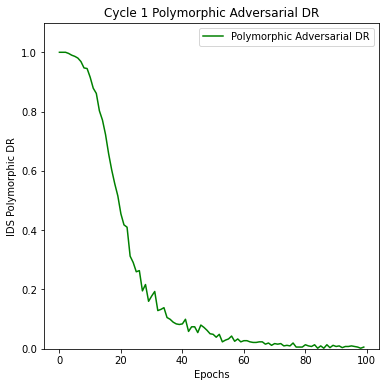

In [34]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, poly_5_dr_vals,color = 'g',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Cycle 1 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

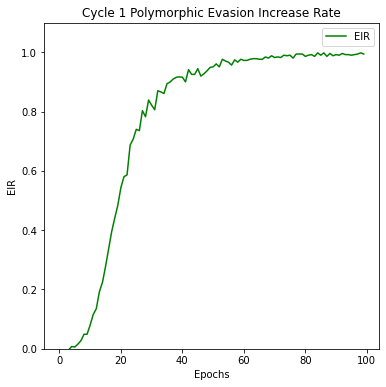

In [35]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_EIR_vals,color = 'g',label = 'EIR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("EIR")
plt.ylim((0,1.1))
plt.title("Cycle 1 Polymorphic Evasion Increase Rate")
plt.legend()

In [188]:
df_poly_ad_5 = pd.DataFrame(poly_ad_data,columns=ad_columns)
df_poly_ad_5.to_csv('poly_ad_data.csv',index=False)

### Detect Poly 5 adversarial after training

In [64]:
test_data_mutated_5 = change_feature_values(th.tensor(test_ad_data).type(th.float),indices)
test_mutated_5_ds = TensorDataset(test_data_mutated_5,th.tensor(np.ones(len(test_ad_data))))

In [65]:
# Load ids trained with polymorphic data 
ids_poly_5_model = load_model('ids_poly_ad5_rf.sav')
epoch = 100

In [38]:
def detect_poly_ad(ids_model_name,poly_attack_data):
   
    test_poly_data = np.empty([0,41])
    adversarial_dr_vals = []
    original_dr_vals = []
    EIR_vals = []
    a_f1_vals = []
    a_recall_vals = []
    a_tnr_vals = []
    labels = ['Epoch', 'O-DR(%)', 'Polymorphic A-DR(%)']
    print(" {: >15} {: >15} {: >15}".format(*labels))
    for i in range(epoch):
        
        attack_dl = DataLoader(poly_attack_data, batch_size=504,shuffle = True)
        benign_dl = DataLoader(test_benign_ds, batch_size=504,shuffle = True)
#         attack_dl = DataLoader(attack_ds, batch_size=511,shuffle = True)
#         benign_dl = DataLoader(benign_ds, batch_size=511,shuffle = True)
       
        
        attack_data,attack_label = iter(attack_dl).next()
        normal_data,normal_label = iter(benign_dl).next()
        
        noise = th.randint(0, 2, size=(len(attack_label), G_INPUT_DIM)).float()
        length = len(attack_data)
        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES['DDoS']
        nonfunctional_feature = attack_data[:, pos_nonfunctional_feature]
        
        attack_traffic = th.cat((noise,nonfunctional_feature),dim = 0)
        l = list(range(length))
        np.random.shuffle(l)
        attack_traffic = attack_traffic[l]
        generator_out = generator(attack_traffic)
        adversarial_attack = gen_adversarial_attack(generator_out, attack_data, attack_category, POS_NONFUNCTIONAL_FEATURES)
        
        adversarial_array =np.array(adversarial_attack.detach())
        test_poly_data = np.concatenate((test_poly_data, adversarial_array), axis=0)
        
        
        origin_dr, adversarial_dr,o_f1_score,a_f1_score,o_recall,a_recall,a_tnr = cal_dr(ids_model_name, normal_data, attack_data, adversarial_attack.detach())
        a_f1_vals.append(a_f1_score)
        a_recall_vals.append(a_recall)
        a_tnr_vals.append(a_tnr)
        #  Calculate evasion increase rate
        EIR = 1 - (adversarial_dr/origin_dr)
        EIR_vals.append(EIR)
        adversarial_dr_vals.append(adversarial_dr)
        original_dr_vals.append(origin_dr)

        print_vals = [(i + 1), (origin_dr*100), (adversarial_dr*100)]
        print_string = []
        for val in print_vals:
                if isinstance(val, float):
                    print_string.append(str(f"{val:.6f}"))
                else:
                    print_string.append(str(val))
        print(" {: >15} {: >15} {: >15}".format(*print_string))
    return adversarial_dr_vals,original_dr_vals,EIR_vals,o_f1_score,a_f1_vals,o_recall,a_recall_vals,a_tnr_vals,test_poly_data 

In [66]:
poly_ad_dr,original_dr_poly_train,EIR_5,poly_retrained_5_o_f1_score,poly_retrained_5_a_f1_score,poly_retrained_5_o_recall,poly_retrained_5_a_recall,poly_retrained_5_tnr,test_poly_data =  detect_poly_ad(ids_poly_5_model,test_mutated_5_ds)

           Epoch         O-DR(%) Polymorphic A-DR(%)
               1       98.437500       97.656250
               2       98.437500       98.242188
               3       98.437500       98.437500
               4       98.437500       98.242188
               5       98.437500       98.242188
               6       98.437500       98.242188
               7       98.437500       98.437500
               8       98.632812       98.632812
               9       98.437500       98.046875
              10       98.437500       98.437500
              11       98.437500       98.046875
              12       98.437500       98.437500
              13       98.437500       98.242188
              14       98.437500       98.242188
              15       98.437500       98.437500
              16       98.437500       98.242188
              17       98.437500       98.437500
              18       98.437500       98.242188
              19       98.437500       97.656250
              20

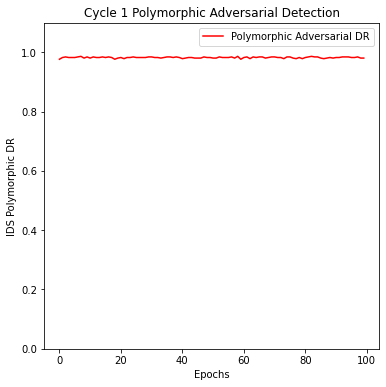

In [67]:
epochs = np.linspace(0, epoch-1, epoch).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, poly_5_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, poly_ad_dr,color = 'r',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim(0,1.1)
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Cycle 1 Polymorphic Adversarial Detection")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Cycle 2 - Create Polymorphic attack data changing 10 features 

In [68]:
# indices_f_10_combine =[14, 15, 16, 17, 18, 19, 20, 21, 22, 31]
indices_f_10_combine =[9,10,11,12,13,14, 15, 16, 17, 18]
data_mutated_10_combine = change_feature_values(attack_data,indices_f_10_combine)
mutated_10_combine_ds = TensorDataset(data_mutated_10_combine,attack_labels)


In [69]:
poly_10_dr_vals,original_poly_10_dr,poly_10_EIR,poly_10_data,poly_attack_10_o_f1_score,poly_attack_10_a_f1_score,poly_attack_10_o_recall,poly_attack_10_a_recall,poly_attack_10_tnr = train_poly(ids_poly_5_model,mutated_10_combine_ds)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.500363       -0.001429       99.609375       98.437500       0.461685
         2       -0.497173       -0.001956       99.609375       97.070312       0.400863
         3       -0.498793       -0.001536       99.609375       94.531250       0.398958
         4       -0.498707       -0.001371       99.804688       93.164062       0.481305
         5       -0.498902       -0.001412       99.804688       91.210938       0.422180
         6       -0.498757       -0.001205       99.804688       90.429688       0.579326
         7       -0.499151       -0.001030       99.609375       89.453125       0.484989
         8       -0.499653       -0.000963       99.414062       87.109375       0.494505
         9       -0.499125       -0.001080       99.609375       84.765625       0.476984
        10       -0.499127       -0.000990       99.804688       86.914062       0.448431
        11

        92       -0.500328       -0.000521       99.609375       33.007812       0.449797
        93       -0.500531       -0.000579       99.414062       37.500000       0.492412
        94       -0.500082       -0.000645       99.804688       34.570312       0.479787
        95       -0.500301       -0.000565       99.609375       33.203125       0.570278
        96       -0.500395       -0.000552       99.414062       33.593750       0.469882
        97       -0.499827       -0.000541       99.609375       31.445312       0.510753
        98       -0.499972       -0.000449       99.414062       30.273438       0.414549
        99       -0.500831       -0.000632       99.609375       32.421875       0.443892
       100       -0.500149       -0.000700       99.414062       29.882812       0.426616


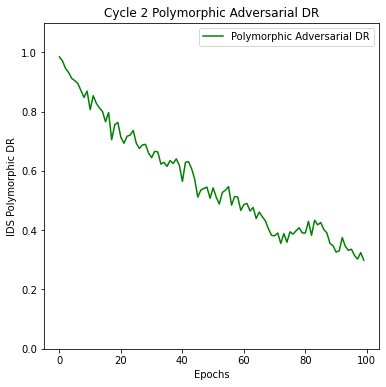

In [70]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_10_dr_vals,color = 'g',label = 'Polymorphic Adversarial DR')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
plt.title("Cycle 2 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

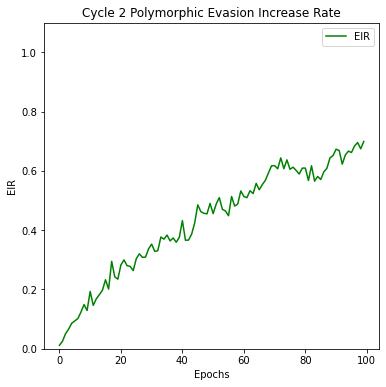

In [71]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_10_EIR,color = 'g',label = 'EIR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("EIR")
plt.ylim((0,1.1))
plt.title("Cycle 2 Polymorphic Evasion Increase Rate")
plt.legend()

##### Save created polymorphic data 

In [ ]:
# Create a dataframe of poly 10 features
df_poly_ad_10 = pd.DataFrame(poly_10_data,columns=ad_columns)
# Get a dataframe of old polymorphic data
df_poly_old_data = pd.read_csv('poly_ad_data.csv')
# Combine old + new 
df_combine_poly = pd.concat([df_poly_old_data,df_poly_ad_10])
# Save polymorphic data into csv file


In [ ]:
df_combine_poly.shape

In [2]:
# df_combine_poly.to_csv('poly_ad_data.csv',index=False)

### Detect poly 10 after training

In [72]:
# Load ids trained with polymorphic data 
ids_poly_10_model = load_model('ids_poly_ad_10_rf.sav')

In [74]:
# test_data_mutated_10 = change_feature_values(test_attack_data,indices_f_10_combine)
# test_mutated_10_ds = TensorDataset(test_data_mutated_10,test_attack_labels)

test_data_mutated_10 = change_feature_values(th.tensor(test_poly_data).type(th.float),indices_f_10_combine)
test_mutated_10_ds = TensorDataset(test_data_mutated_10,th.tensor(np.ones(len(test_poly_data))))

In [75]:
poly_dr_10,original_poly_10_train,EIR_10,poly_retrained_10_o_f1_score,poly_retrained_10_a_f1_score,poly_retrained_10_o_recall,poly_retrained_10_a_recall,poly_retrained_10_tnr,test_poly_2_data  =  detect_poly_ad(ids_poly_10_model,test_mutated_10_ds)

           Epoch         O-DR(%) Polymorphic A-DR(%)
               1       98.437500       98.242188
               2       98.437500       98.437500
               3       98.437500       98.437500
               4       98.632812       98.632812
               5       98.437500       98.242188
               6       98.437500       98.437500
               7       98.437500       98.437500
               8       98.437500       98.242188
               9       98.437500       98.437500
              10       98.437500       98.437500
              11       98.437500       98.437500
              12       98.437500       98.437500
              13       98.437500       98.242188
              14       98.437500       98.437500
              15       98.437500       98.242188
              16       98.632812       98.632812
              17       98.437500       98.242188
              18       98.437500       98.437500
              19       98.437500       98.437500
              20

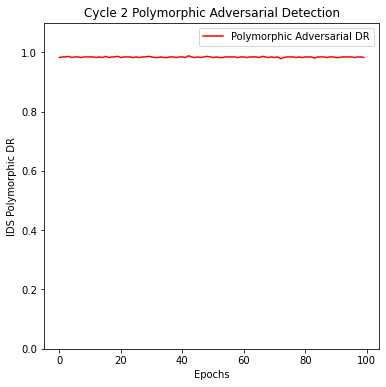

In [76]:
epochs = np.linspace(0, epoch-1, epoch).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_poly_10_train,color = 'g',label = 'Original DR')
plt.plot(epochs, poly_dr_10,color = 'r',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Cycle 2 Polymorphic Adversarial Detection")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Cycle 3 - Create Polymorphic attack data changing 15 features  

In [78]:
indices_f_15 =[9,10,11,12,13,14, 15, 16, 17, 18, 19, 20, 21, 22, 31]
data_mutated_15 = change_feature_values(attack_data,indices_f_15)
mutated_15_ds = TensorDataset(data_mutated_15,attack_labels)


In [79]:
poly_15_dr_vals,original_poly_15_dr,poly_15_EIR,poly_15_data,poly_attack_15_o_f1_score,poly_attack_15_a_f1_score,poly_attack_15_o_recall,poly_attack_15_a_recall,poly_attack_15_tnr = train_poly(ids_poly_10_model,mutated_15_ds)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.499916       -0.000678       99.414062       99.414062       0.474396
         2       -0.496055       -0.001611       99.609375       98.828125       0.417350
         3       -0.499039       -0.001218       99.414062       99.609375       0.423844
         4       -0.499423       -0.001309       99.804688       98.828125       0.409372
         5       -0.499466       -0.001009       99.414062       99.609375       0.385808
         6       -0.498711       -0.001193       99.414062       98.828125       0.487593
         7       -0.498368       -0.000965      100.000000       99.414062       0.418702
         8       -0.499426       -0.000990      100.000000       97.851562       0.417735
         9       -0.499470       -0.001071       99.804688       98.242188       0.392282
        10       -0.499945       -0.000982       99.414062       98.437500       0.410226
        11

        92       -0.500749       -0.000887       99.609375       83.789062       0.401878
        93       -0.500550       -0.001053      100.000000       83.789062       0.446499
        94       -0.499675       -0.001097       99.414062       83.203125       0.476338
        95       -0.498408       -0.001301       99.218750       81.250000       0.400795
        96       -0.499241       -0.000809       99.804688       78.320312       0.446738
        97       -0.498702       -0.001015       99.609375       78.125000       0.436502
        98       -0.499265       -0.000951       99.609375       76.562500       0.426846
        99       -0.499472       -0.001313       99.414062       81.250000       0.629042
       100       -0.500030       -0.001054       99.609375       81.835938       0.559275


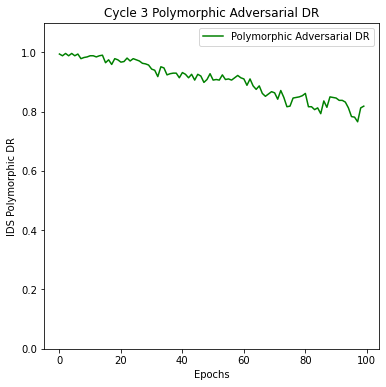

In [80]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_15_dr_vals,color = 'g',label = 'Polymorphic Adversarial DR')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
plt.title("Cycle 3 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

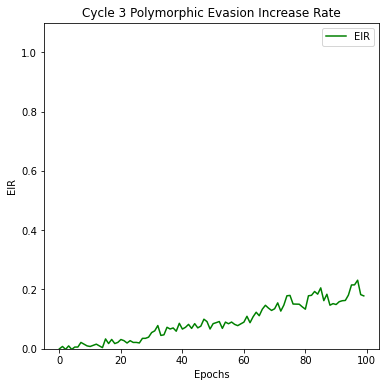

In [81]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_15_EIR,color = 'g',label = 'EIR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("EIR")
plt.ylim((0,1.1))
plt.title("Cycle 3 Polymorphic Evasion Increase Rate")
plt.legend()

In [ ]:
# Create a dataframe of poly 15 features
df_poly_ad_15 = pd.DataFrame(poly_15_data,columns=ad_columns)
# Get a dataframe of old polymorphic data
df_poly_old_data = pd.read_csv('poly_ad_data.csv')
# # Combine old + new 
df_combine_poly = pd.concat([df_poly_old_data,df_poly_ad_15])
# # Save polymorphic data into csv file
# df_combine_poly

In [ ]:
df_combine_poly.shape

In [ ]:
df_combine_poly.to_csv('poly_ad_data.csv',index=False)

### Detect Poly 15 after training 

In [84]:
ids_ploy_ad_15_name = 'ids_poly_ad_15_rf.sav'
ids_poly_15_model = load_model(ids_ploy_ad_15_name)

In [85]:
# test_data_mutated_15 = change_feature_values(test_attack_data,indices_f_15)
# test_mutated_15_ds = TensorDataset(test_data_mutated_15,test_attack_labels)

test_data_mutated_15 = change_feature_values(th.tensor(test_poly_2_data).type(th.float),indices_f_15)
test_mutated_15_ds = TensorDataset(test_data_mutated_15,th.tensor(np.ones(len(test_poly_2_data))))


In [86]:
poly_dr_15,original_poly_15_train,EIR_15,poly_retrained_15_o_f1_score,poly_retrained_15_a_f1_score,poly_retrained_15_o_recall,poly_retrained_15_a_recall,poly_retrained_15_tnr,test_poly_3_data  =  detect_poly_ad(ids_poly_15_model,test_mutated_15_ds)

           Epoch         O-DR(%) Polymorphic A-DR(%)
               1       98.437500       98.437500
               2       98.437500       98.437500
               3       98.437500       98.437500
               4       98.437500       98.437500
               5       98.437500       98.437500
               6       98.828125       98.828125
               7       98.437500       98.437500
               8       98.632812       98.632812
               9       98.437500       98.437500
              10       98.437500       98.437500
              11       98.437500       98.437500
              12       98.437500       98.437500
              13       98.437500       98.437500
              14       98.437500       98.437500
              15       98.437500       98.437500
              16       98.437500       98.437500
              17       98.437500       98.437500
              18       98.437500       98.437500
              19       98.437500       98.437500
              20

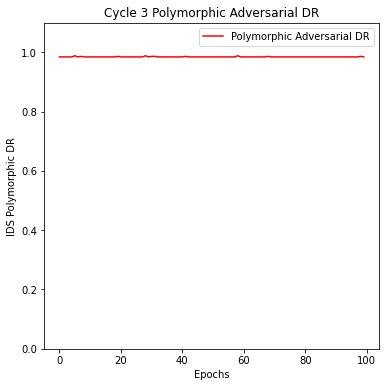

In [87]:
epochs = np.linspace(0, epoch-1, epoch).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_dr_15,color = 'r',label = 'Polymorphic Adversarial DR')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
plt.title("Cycle 3 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Cycle 4 -  Create Polymorphic attack data changing 20 features

In [88]:
indices_f_20 =[9,10,11,12,13,14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36]
data_mutated_20 = change_feature_values(attack_data,indices_f_20)
mutated_20_ds = TensorDataset(data_mutated_20,attack_labels)

In [89]:
poly_20_dr_vals,original_poly_20_dr,poly_20_EIR,poly_20_data,poly_attack_20_o_f1_score,poly_attack_20_a_f1_score,poly_attack_20_o_recall,poly_attack_20_a_recall,poly_attack_20_tnr = train_poly(ids_poly_15_model,mutated_20_ds)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.500698       -0.001210       99.609375      100.000000       0.496147
         2       -0.498627       -0.001169       99.414062      100.000000       0.389133
         3       -0.499261       -0.000979       99.218750      100.000000       0.457743
         4       -0.498926       -0.001135       99.218750      100.000000       0.455284
         5       -0.499983       -0.001227       99.609375      100.000000       0.400898
         6       -0.499596       -0.000894      100.000000      100.000000       0.394377
         7       -0.500426       -0.000889       99.609375      100.000000       0.408788
         8       -0.499419       -0.001195       99.804688      100.000000       0.459355
         9       -0.499063       -0.001141      100.000000      100.000000       0.401031
        10       -0.498531       -0.000867       99.804688      100.000000       0.428371
        11

        92       -0.500080       -0.001115       99.609375      100.000000       0.506204
        93       -0.499260       -0.001173       99.804688      100.000000       0.394813
        94       -0.499841       -0.001035       99.804688      100.000000       0.514510
        95       -0.499594       -0.000980      100.000000      100.000000       0.410082
        96       -0.499797       -0.001211       99.804688      100.000000       0.492938
        97       -0.499371       -0.000987       99.609375      100.000000       0.404971
        98       -0.498229       -0.001311       99.609375      100.000000       0.385834
        99       -0.498895       -0.000932      100.000000      100.000000       0.416651
       100       -0.498655       -0.001005       99.804688      100.000000       0.731743


AttributeError: module 'matplotlib.pyplot' has no attribute 'ylime'

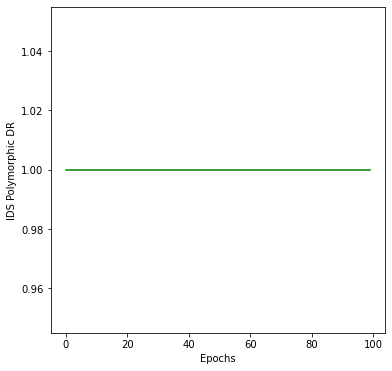

In [90]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_20_dr_vals,color = 'g',label = 'Polymorphic Adversarial DR')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylime((0,1.1))
plt.title("Cycle 4 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

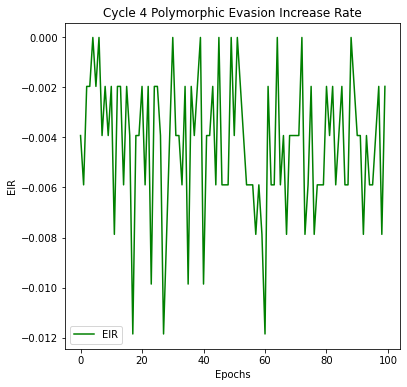

In [328]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, poly_20_EIR,color = 'g',label = 'EIR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("EIR")
plt.title("Cycle 4 Polymorphic Evasion Increase Rate")
plt.legend()

# Algorithm 2 - Polymorphic adversarial data generation  

## Cycle 1 - Change 3 features 

In [ ]:
# 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40

In [134]:
num_epochs = 100
indices_cycle_1 =[9,10,11]
data_mutated_cycle_1 = change_feature_values(attack_data,indices_cycle_1)
ds_cycle_1 = TensorDataset(data_mutated_cycle_1,attack_labels)

In [135]:
cycle_1_poly_dr,cycle_1_original_dr,cycle_1_poly_EIR,cycle_1_poly_ad_data,p_attack_cycle1_o_f1_score,p_attack_cycle1_a_f1_score,p_attack_cycle1_o_recall,p_attack_cycle1_a_recall,p_attack_cycle1__tnr = train_poly(ids_ad_model,ds_cycle_1)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.504493       -0.004360      100.000000      100.000000       0.488610
         2       -0.460455       -0.015335       99.609375      100.000000       0.493908
         3       -0.476217       -0.014668       99.609375      100.000000       0.424421
         4       -0.480837       -0.013620       99.414062      100.000000       0.422844
         5       -0.483730       -0.013173       99.609375      100.000000       0.515560
         6       -0.485330       -0.012586       99.414062      100.000000       0.387550
         7       -0.486837       -0.011862       99.609375      100.000000       0.459936
         8       -0.487717       -0.011546       99.804688      100.000000       0.492461
         9       -0.488741       -0.010643       99.609375      100.000000       0.546096
        10       -0.490052       -0.010466      100.000000      100.000000       0.428398
        11

        92       -0.501270       -0.001508       99.609375        1.562500       0.401903
        93       -0.501222       -0.002118      100.000000        1.367188       0.451811
        94       -0.501093       -0.001627       99.218750        0.585938       0.446878
        95       -0.500728       -0.001760       99.218750        1.757812       0.425549
        96       -0.500609       -0.002042       99.414062        1.367188       0.414658
        97       -0.500919       -0.001534       99.023438        1.562500       0.442280
        98       -0.501099       -0.002508       98.828125        1.562500       0.418959
        99       -0.501409       -0.002169      100.000000        1.562500       0.399339
       100       -0.501606       -0.002433       99.804688        1.367188       0.411042


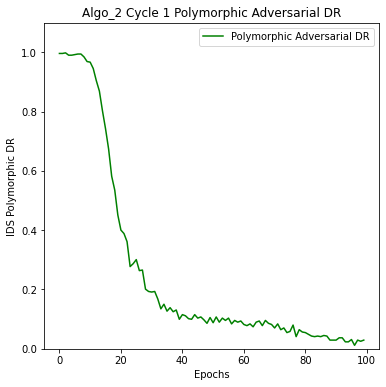

In [116]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, cycle_1_poly_dr,color = 'g',label = 'Polymorphic Adversarial DR')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
plt.title("Algo_2 Cycle 1 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

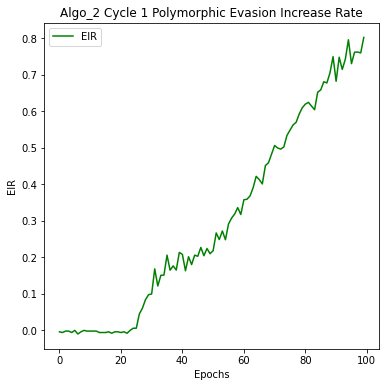

In [1446]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, cycle_1_poly_EIR,color = 'g',label = 'EIR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("EIR")
plt.title("Algo_2 Cycle 1 Polymorphic Evasion Increase Rate")
plt.legend()

In [361]:
cycle_1_poly_ad_data.shape

(51200, 41)

In [362]:
df_cycle_1_poly = pd.DataFrame(cycle_1_poly_ad_data,columns=ad_columns)
df_cycle_1_poly.to_csv('poly_ad_data_algo_2.csv',index=False)

### Cycle 1 - Detect poly after training 

In [136]:
ids_poly_cycle_1 = 'ids_poly_cycle_1_rf.sav'
ids_poly_cycle_1_model = load_model(ids_poly_cycle_1)



In [137]:
test_data_cycle_1 = change_feature_values(th.tensor(test_ad_data).type(th.float),indices_cycle_1)
ds_test_cycle_1 = TensorDataset(test_data_cycle_1,th.tensor(np.ones(len(test_ad_data))))

In [138]:
poly_dr_cycle_1,original_poly_cycle_1_train,EIR_cycle_1,p_retrained_cycle1_o_f1_score,p_retrained_cycle1_a_f1_score,p_retrained_cycle1_o_recall,p_retrained_cycle1_a_recall,p_retrained_cycle1__tnr,test_poly_cycle_1 =  detect_poly_ad(ids_poly_cycle_1_model,ds_test_cycle_1)

           Epoch         O-DR(%) Polymorphic A-DR(%)
               1       98.437500       71.093750
               2       98.437500       68.945312
               3       98.437500       68.554688
               4       98.828125       69.140625
               5       98.437500       71.289062
               6       98.437500       64.453125
               7       98.437500       69.335938
               8       98.437500       68.750000
               9       98.437500       69.921875
              10       98.437500       70.312500
              11       98.437500       66.601562
              12       98.437500       67.968750
              13       98.437500       68.359375
              14       98.437500       69.921875
              15       98.437500       69.335938
              16       98.437500       70.117188
              17       98.437500       71.093750
              18       98.437500       70.507812
              19       98.437500       68.945312
              20

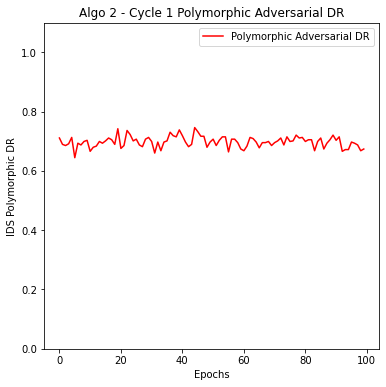

In [139]:
epochs = np.linspace(0, epoch-1, epoch).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, poly_dr_cycle_1,color = 'r',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Algo 2 - Cycle 1 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Cycle 2 - Change 6 features 

In [140]:
num_epochs = 100
indices_cycle_2 =[12, 13, 14, 15, 16, 17]
data_mutated_cycle_2 = change_feature_values(attack_data,indices_cycle_2)
ds_cycle_2 = TensorDataset(data_mutated_cycle_2,attack_labels)

In [141]:
cycle_2_poly_dr,cycle_2_original_dr,cycle_2_poly_EIR,cycle_2_poly_ad_data,p_attack_cycle2_o_f1_score,p_attack_cycle2_a_f1_score,p_attack_cycle2_o_recall,p_attack_cycle2_a_recall,p_attack_cycle2__tnr = train_poly(ids_poly_cycle_1_model,ds_cycle_2)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.501282       -0.000486       99.804688       57.421875       0.447117
         2       -0.497782       -0.001022       99.414062       54.882812       0.404643
         3       -0.498321       -0.000789       99.609375       55.273438       0.448768
         4       -0.498447       -0.000801       99.414062       55.664062       0.432488
         5       -0.498618       -0.000702       99.414062       51.953125       0.414661
         6       -0.498869       -0.000773       99.414062       47.460938       0.440550
         7       -0.497146       -0.000671       99.023438       46.875000       0.414105
         8       -0.497679       -0.000690       99.609375       52.343750       0.595802
         9       -0.497605       -0.000509       99.414062       50.390625       0.540542
        10       -0.498398       -0.000530       99.609375       48.632812       0.457969
        11

        92       -0.499940       -0.000609       99.609375       17.187500       0.391350
        93       -0.500491       -0.000514       99.609375       20.312500       0.509274
        94       -0.500393       -0.000623       99.609375       17.187500       0.453237
        95       -0.499974       -0.000702       99.218750       16.796875       0.404015
        96       -0.500024       -0.000680       99.609375       18.164062       0.409150
        97       -0.498560       -0.000576       99.609375       19.921875       0.433064
        98       -0.498282       -0.000710      100.000000       19.921875       0.418958
        99       -0.498925       -0.000491       99.609375       19.140625       0.429164
       100       -0.499933       -0.000595       98.632812       19.140625       0.415592


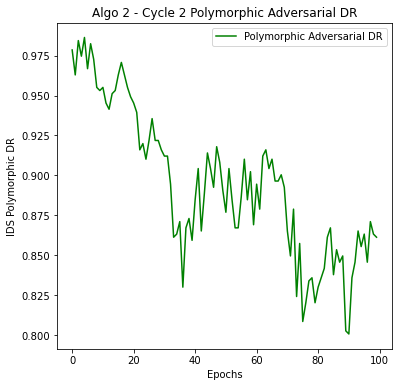

In [1452]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, cycle_2_poly_dr,color = 'g',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Algo 2 - Cycle 2 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

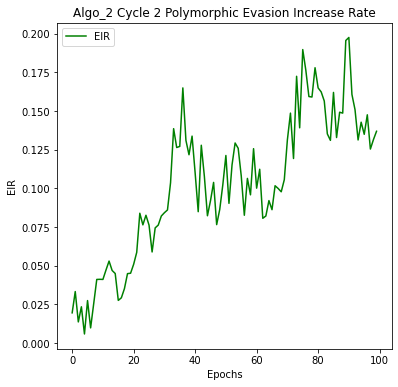

In [1453]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, cycle_2_poly_EIR,color = 'g',label = 'EIR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("EIR")
plt.title("Algo_2 Cycle 2 Polymorphic Evasion Increase Rate")
plt.legend()

In [364]:
# Create a dataframe of poly 15 features
df_poly_cycle_2 = pd.DataFrame(cycle_2_poly_ad_data,columns=ad_columns)
# Get a dataframe of old polymorphic data
df_poly_old = pd.read_csv('poly_ad_data_algo_2.csv')
# # Combine old + new 
df_combine_data = pd.concat([df_poly_old,df_poly_cycle_2])
# # Save polymorphic data into csv file
df_combine_data.to_csv('poly_ad_data_algo_2.csv',index=False)

### Cycle 2 - Detect poly after training

In [142]:
ids_poly_cycle_2 = 'ids_poly_cycle_2_rf.sav'
ids_poly_cycle_2_model = load_model(ids_poly_cycle_2)

In [145]:
test_data_cycle_2 = change_feature_values(th.tensor(test_poly_cycle_1).type(th.float),indices_cycle_2)
ds_test_cycle_2 = TensorDataset(test_data_cycle_2,th.tensor(np.ones(len(test_poly_cycle_1))))

In [146]:
poly_dr_cycle_2,original_poly_cycle_2_train,EIR_cycle_2,p_retrained_cycle2_o_f1_score,p_retrained_cycle2_a_f1_score,p_retrained_cycle2_o_recall,p_retrained_cycle2_a_recall,p_retrained_cycle2__tnr,test_poly_cycle_2 =  detect_poly_ad(ids_poly_cycle_2_model,ds_test_cycle_2)

           Epoch         O-DR(%) Polymorphic A-DR(%)
               1       95.312500       90.429688
               2       96.289062       90.039062
               3       95.312500       90.234375
               4       96.679688       90.429688
               5       97.265625       86.914062
               6       96.875000       91.406250
               7       95.507812       89.843750
               8       95.117188       88.281250
               9       96.484375       91.210938
              10       94.921875       90.234375
              11       95.507812       90.625000
              12       96.093750       88.476562
              13       95.703125       88.867188
              14       96.093750       89.257812
              15       96.093750       89.257812
              16       97.460938       87.695312
              17       95.898438       91.796875
              18       95.703125       91.210938
              19       94.726562       91.601562
              20

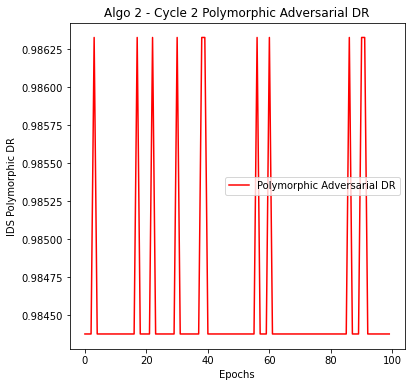

In [1456]:
epochs = np.linspace(0, epoch-1, epoch).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, poly_dr_cycle_2,color = 'r',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Algo 2 - Cycle 2 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

## Cycle 3 - Change 9 features 

In [147]:
indices_cycle_3 =[18, 19, 20, 21, 22, 31, 32, 33, 34]
data_mutated_cycle_3 = change_feature_values(attack_data,indices_cycle_3)
ds_cycle_3 = TensorDataset(data_mutated_cycle_3,attack_labels)

In [149]:
cycle_3_poly_dr,cycle_3_original_dr,cycle_3_poly_EIR,cycle_3_poly_ad_data,p_attack_cycle3_o_f1_score,p_attack_cycle3_a_f1_score,p_attack_cycle3_o_recall,p_attack_cycle3_a_recall,p_attack_cycle3__tnr = train_poly(ids_poly_cycle_2_model,ds_cycle_3)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.499852       -0.001259       99.414062      100.000000       0.481701
         2       -0.498478       -0.001047       99.804688      100.000000       0.422672
         3       -0.498152       -0.000942       99.804688      100.000000       0.433427
         4       -0.500137       -0.001195       99.609375      100.000000       0.412965
         5       -0.498817       -0.000926       99.609375      100.000000       0.443075
         6       -0.499623       -0.001067       99.609375      100.000000       0.438436
         7       -0.500708       -0.001001       99.218750      100.000000       0.403658
         8       -0.500326       -0.000912       99.414062      100.000000       0.474408
         9       -0.500282       -0.001021       99.609375      100.000000       0.502403
        10       -0.498805       -0.001030       99.414062      100.000000       0.473941
        11

        92       -0.499879       -0.000881       99.414062      100.000000       0.416039
        93       -0.499073       -0.000957       99.609375      100.000000       0.414137
        94       -0.498893       -0.001165       99.804688      100.000000       0.388017
        95       -0.499810       -0.000907      100.000000      100.000000       0.434710
        96       -0.500293       -0.001086       99.609375      100.000000       0.456832
        97       -0.500780       -0.001063       99.609375      100.000000       0.441762
        98       -0.499891       -0.001213       99.804688      100.000000       0.398988
        99       -0.500034       -0.001112       99.609375      100.000000       0.420114
       100       -0.500885       -0.000891       99.023438      100.000000       0.404370


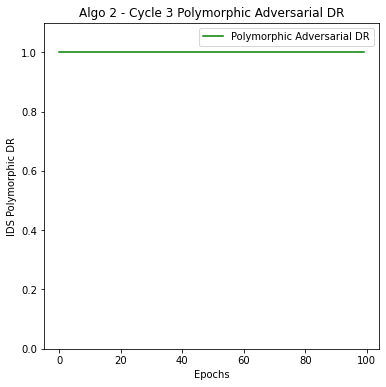

In [150]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, cycle_3_poly_dr,color = 'g',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((0,1.1))
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Algo 2 - Cycle 3 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

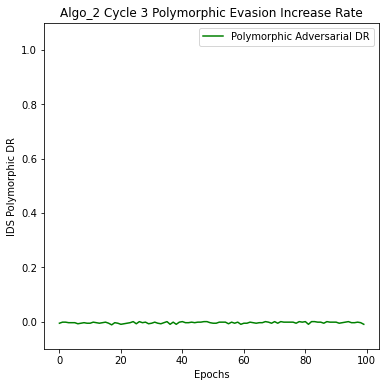

In [152]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, cycle_3_poly_EIR,color = 'g',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
plt.ylim((-0.1,1.1))
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Algo_2 Cycle 3 Polymorphic Evasion Increase Rate")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Cycle_4 Change remaining 6 features 

In [153]:
num_epochs = 100
indices_cycle_4 =[35, 36, 37, 38, 39, 40]
data_mutated_cycle_4 = change_feature_values(attack_data,indices_cycle_4)
ds_cycle_4 = TensorDataset(data_mutated_cycle_4,attack_labels)

In [154]:
cycle_4_poly_dr,cycle_4_original_dr,cycle_4_poly_EIR,cycle_4_poly_ad_data,p_attack_cycle4_o_f1_score,p_attack_cycle4_a_f1_score,p_attack_cycle4_o_recall,p_attack_cycle4_a_recall,p_attack_cycle4__tnr = train_poly(ids_poly_cycle_2_model,ds_cycle_4)

     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)     Runtime(s)
         1       -0.500001       -0.001327       99.804688      100.000000       0.442036
         2       -0.497308       -0.000891       99.804688      100.000000       0.404056
         3       -0.499600       -0.001068       99.804688      100.000000       0.421631
         4       -0.499376       -0.000899       99.609375      100.000000       0.486657
         5       -0.499871       -0.001208       99.414062      100.000000       0.413871
         6       -0.500457       -0.000760       99.804688      100.000000       0.421150
         7       -0.499660       -0.000904       99.609375      100.000000       0.390514
         8       -0.499301       -0.000959       99.414062      100.000000       0.384925
         9       -0.498334       -0.001291       99.804688      100.000000       0.415615
        10       -0.498927       -0.001044      100.000000      100.000000       0.368615
        11

        92       -0.500508       -0.001132      100.000000      100.000000       0.496552
        93       -0.500422       -0.001042       99.804688      100.000000       0.463569
        94       -0.500528       -0.000956      100.000000      100.000000       0.440696
        95       -0.499498       -0.000912       99.023438      100.000000       0.572437
        96       -0.498803       -0.001089       99.609375      100.000000       0.577755
        97       -0.498897       -0.000936      100.000000      100.000000       0.531590
        98       -0.499292       -0.001042       99.609375      100.000000       0.458598
        99       -0.500012       -0.000968       99.218750      100.000000       0.640921
       100       -0.499821       -0.000994       99.609375      100.000000       0.788351


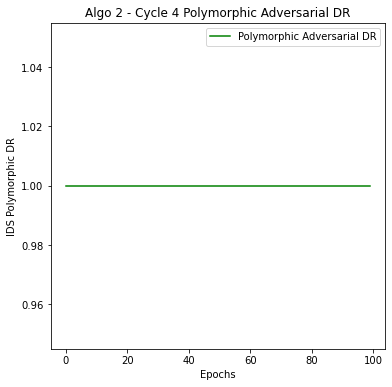

In [1464]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, cycle_4_poly_dr,color = 'g',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Algo 2 - Cycle 4 Polymorphic Adversarial DR")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

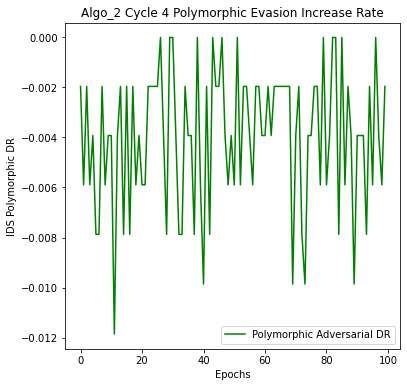

In [1465]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
# plt.plot(epochs, original_dr_vals,color = 'g',label = 'Original DR')
plt.plot(epochs, cycle_4_poly_EIR,color = 'g',label = 'Polymorphic Adversarial DR')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS Polymorphic DR")
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Algo_2 Cycle 4 Polymorphic Evasion Increase Rate")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

## Results  collection for Algo 1

In [91]:
# RF_DATA = [adversarial_dr_vals,EIR_vals,ad_dr_after_training,EIR_after_training,poly_5_dr_vals,poly_EIR_vals,poly_ad_dr,EIR_5,
#           poly_10_dr_vals,poly_10_EIR,poly_dr_10,EIR_10,poly_15_dr_vals,poly_15_EIR,poly_dr_15,EIR_15,poly_20_dr_vals,poly_20_EIR,
#           a_f1_score,a_recall,a_f1_score_retrained,a_recall_retrained, poly_attack_5_a_f1_score,poly_attack_5_a_recall,poly_retrained_5_a_f1_score,
#            poly_retrained_5_a_recall,poly_attack_10_a_f1_score,poly_attack_10_a_recall,poly_retrained_10_a_f1_score,poly_retrained_10_a_recall,
#            poly_attack_15_a_f1_score,poly_attack_15_a_recall,poly_retrained_15_a_f1_score,poly_retrained_15_a_recall,poly_attack_20_a_f1_score,poly_attack_20_a_recall]

RF_DATA_Column_name = ['ADR_attack','AD_EIR_attack','ADR_retrained','AD_EIR_retrained','PADR_attack_1','EIR_attack_1','PADR_retrained_1',
                      'EIR_retrained_1','PADR_attack_2','EIR_attack_2','PADR_retrained_2',
                      'EIR_retrained_2','PADR_attack_3','EIR_attack_3','PADR_retrained_3',
                      'EIR_retrained_3','PADR_attack_4','EIR_attack_4','a_f1','a_recall',
                       'a_f1_retrained','a_recall_retrained','p_attack_5_a_f1','p_attack_5_a_recall',
                       'p_retrained_5_a_f1','p_retrained_5_a_recall','p_attack_10_a_f1',
                       'p_attack_10_a_recall','p_retrained_10_a_f1','p_retrained_10_a_recall',
                       'p_attack_15_a_f1','p_attack_15_a_recall','p_retrained_15_a_f1',
                       'p_retrained_15_a_recall','p_attack_20_a_f1','p_attack_20_a_recall','a_tnr','a_tnr_retrained',
                       'p_attack_5_tnr','p_retrained_5_tnr','p_attack_10_tnr','p_retrained_10_tnr','p_attack_15_tnr','p_retrained_15_tnr','p_attack_20_tnr']

In [92]:
df_RF_Data = pd.DataFrame(list(zip(adversarial_dr_vals,EIR_vals,ad_dr_after_training,EIR_after_training,poly_5_dr_vals,poly_EIR_vals,poly_ad_dr,EIR_5,
          poly_10_dr_vals,poly_10_EIR,poly_dr_10,EIR_10,poly_15_dr_vals,poly_15_EIR,poly_dr_15,EIR_15,poly_20_dr_vals,poly_20_EIR,
          a_f1_score,a_recall,a_f1_score_retrained,a_recall_retrained, poly_attack_5_a_f1_score,poly_attack_5_a_recall,poly_retrained_5_a_f1_score,
           poly_retrained_5_a_recall,poly_attack_10_a_f1_score,poly_attack_10_a_recall,poly_retrained_10_a_f1_score,poly_retrained_10_a_recall,
           poly_attack_15_a_f1_score,poly_attack_15_a_recall,poly_retrained_15_a_f1_score,poly_retrained_15_a_recall,poly_attack_20_a_f1_score,poly_attack_20_a_recall,
          a_tnr,a_tnr_retrained,poly1_attack_tnr,poly_retrained_5_tnr,poly_attack_10_tnr,poly_retrained_10_tnr,poly_attack_15_tnr,poly_retrained_15_tnr,poly_attack_20_tnr)),
               columns = RF_DATA_Column_name)

In [93]:
# df_RF_Data.to_csv('RF_DATA_1.csv',index=False)

In [94]:
# df_RF = pd.read_csv('RF_DATA.csv')
df_RF = pd.read_csv('RF_DATA_1.csv')

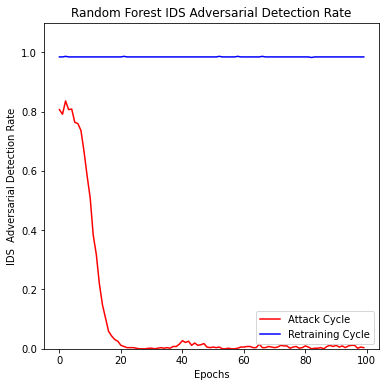

In [96]:
plt.figure(figsize=(6,6))
plt.plot(epochs, df_RF['ADR_attack'],color = 'r',label = 'Attack Cycle')
plt.plot(epochs, df_RF['ADR_retrained'],color = 'b',label = 'Retraining Cycle')
# plt.plot(epochs, ad_dr_after_training,color = 'b',label = 'Retraining Cycle',)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS  Adversarial Detection Rate")
plt.ylim((0,1.1))
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Random Forest IDS Adversarial Detection Rate")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

### Graph of Detection Rate 

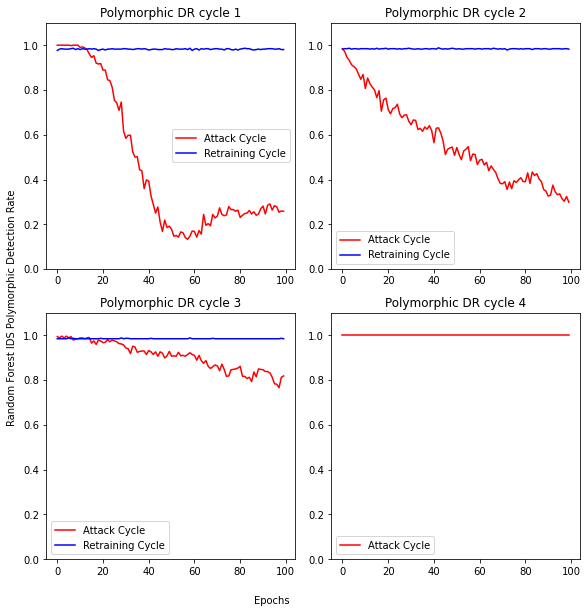

In [97]:
# Placing the plots in the plane
fig = plt.figure(figsize=(12,12))


plot1 = plt.subplot2grid((3, 3), (0, 0),rowspan=1,colspan=1)
plot2 = plt.subplot2grid((3, 3), (0, 1),rowspan=1,colspan=1)
plot3 = plt.subplot2grid((3, 3), (1, 0),rowspan=1,colspan=1)
plot4 = plt.subplot2grid((3, 3), (1, 1),rowspan=1,colspan=1)


# Plot for PDAR 1
plot1.plot(epochs, df_RF['PADR_attack_1'], color='r')
plot1.plot(epochs, df_RF['PADR_retrained_1'], color='b')
plot1.set_title('Polymorphic DR cycle 1')
plot1.set_ylim((0,1.1))
plot1.legend(labels=['Attack Cycle', 'Retraining Cycle'])


# Plot for PDAR 2
plot2.plot(epochs, df_RF['PADR_attack_2'], color='r')
plot2.plot(epochs, df_RF['PADR_retrained_2'], color='b')
plot2.set_title('Polymorphic DR cycle 2')
plot2.set_ylim((0,1.1))
plot2.legend(labels=['Attack Cycle', 'Retraining Cycle'])

# Plot for PDAR 3
plot3.plot(epochs, df_RF['PADR_attack_3'], color='r')
plot3.plot(epochs, df_RF['PADR_retrained_3'], color='b')
plot3.set_title('Polymorphic DR cycle 3')
plot3.set_ylim((0,1.1))
plot3.legend(labels=['Attack Cycle', 'Retraining Cycle'])


# Plot for PDAR 3
plot4.plot(epochs, df_RF['PADR_attack_4'], color='r')
plot4.set_title('Polymorphic DR cycle 4')
plot4.set_ylim((0,1.1))
plot4.legend(labels=['Attack Cycle', 'Retraining Cycle'])

fig.text(0.3,0.3,'Epochs',ha = 'center',va = 'center')
fig.text(0.00005,0.64,'Random Forest IDS Polymorphic Detection Rate',ha = 'center',va = 'center',rotation = 'vertical')

  
# Packing all the plots and displaying them
plt.tight_layout()



  

### Overall Detection Rate 

Text(0, 0.5, 'Random Forest Overall IDS Detection Rate')

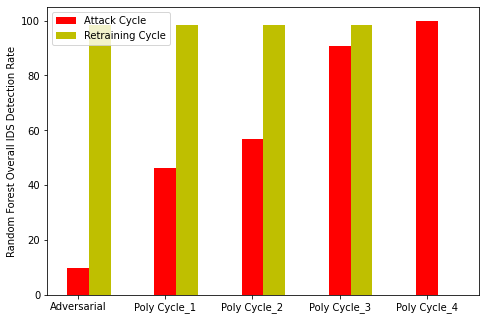

In [98]:
cycles = ['Adversarial','Poly Cycle_1', 'Poly Cycle_2', 'Poly Cycle_3', 'Poly Cycle_4']
total_DR_Attack = [df_RF['ADR_attack'].sum(),df_RF['PADR_attack_1'].sum(),df_RF['PADR_attack_2'].sum(),df_RF['PADR_attack_3'].sum(),df_RF['PADR_attack_4'].sum()
            ]
total_DR_Retrained = [df_RF['ADR_retrained'].sum(),df_RF['PADR_retrained_1'].sum(),df_RF['PADR_retrained_2'].sum(),df_RF['PADR_retrained_3'].sum(),0
            ]

X = np.arange(5)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cycles, total_DR_Attack, color = 'r', width = 0.25,label = 'Attack Cycle')
ax.bar(X + 0.25, total_DR_Retrained, color = 'y', width = 0.25)
ax.legend(labels=['Attack Cycle', 'Retraining Cycle'])
ax.set_ylabel('Random Forest Overall IDS Detection Rate')



### Overall EIR 

Text(0.5, 1.0, 'Random Forest EIR')

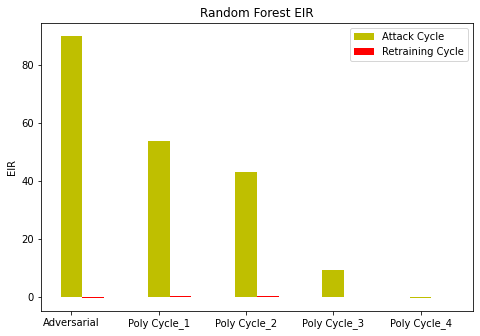

In [101]:
cycles = ['Adversarial','Poly Cycle_1', 'Poly Cycle_2', 'Poly Cycle_3', 'Poly Cycle_4']
total_EIR_Attack = [df_RF['AD_EIR_attack'].sum(),df_RF['EIR_attack_1'].sum(),df_RF['EIR_attack_2'].sum(),df_RF['EIR_attack_3'].sum(),df_RF['EIR_attack_4'].sum()
            ]
total_EIR_Retrained = [df_RF['AD_EIR_retrained'].sum(),df_RF['EIR_retrained_1'].sum(),df_RF['EIR_retrained_2'].sum(),df_RF['EIR_retrained_3'].sum(),0
            ]

X = np.arange(5)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cycles, total_EIR_Attack, color = 'y', width = 0.25,label = 'Attack Cycle')
ax.bar(X + 0.25, total_EIR_Retrained, color = 'r', width = 0.25)
ax.legend(labels=['Attack Cycle', 'Retraining Cycle'])
ax.set_ylabel('EIR')
ax.set_title('Random Forest EIR')

### Overall F1 Score and Recall  

Text(0.5, 1.0, 'Random Forest F1 Score,Recall and TNR')

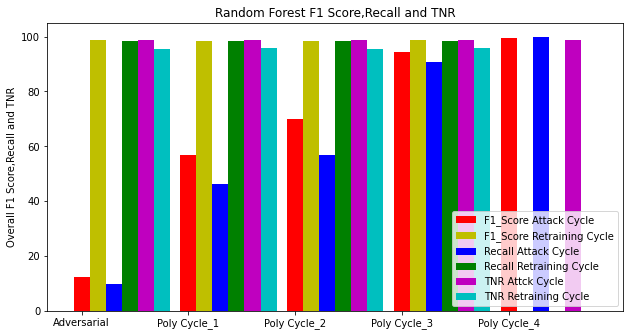

In [102]:
cycles = ['Adversarial','Poly Cycle_1', 'Poly Cycle_2', 'Poly Cycle_3', 'Poly Cycle_4']
total_F1_Attack = [df_RF['a_f1'].sum(),df_RF['p_attack_5_a_f1'].sum(),df_RF['p_attack_10_a_f1'].sum(),df_RF['p_attack_15_a_f1'].sum(),df_RF['p_attack_20_a_f1'].sum()
            ]
total_F1_Retrained = [df_RF['a_f1_retrained'].sum(),df_RF['p_retrained_5_a_f1'].sum(),
                      df_RF['p_retrained_10_a_f1'].sum(),df_RF['p_retrained_15_a_f1'].sum(),
                      0
            ]
total_Recall_Attack = [df_RF['a_recall'].sum(),df_RF['p_attack_5_a_recall'].sum(),df_RF['p_attack_10_a_recall'].sum(),df_RF['p_attack_15_a_recall'].sum(),df_RF['p_attack_20_a_recall'].sum()
            ]
total_Recall_Retrained = [df_RF['a_recall_retrained'].sum(),df_RF['p_retrained_5_a_recall'].sum(),
                          df_RF['p_retrained_10_a_recall'].sum(),
                          df_RF['p_retrained_15_a_recall'].sum(),0
            ]
TNR_Attack = [df_RF['a_tnr'].mean(),df_RF['p_attack_5_tnr'].mean(),df_RF['p_attack_10_tnr'].mean(),
              df_RF['p_attack_15_tnr'].mean(),df_RF['p_attack_20_tnr'].mean()
            ]
TNR_Retrained = [df_RF['a_tnr_retrained'].mean(),df_RF['p_retrained_5_tnr'].mean(),df_RF['p_retrained_10_tnr'].mean(),
              df_RF['p_retrained_15_tnr'].mean(),0
            ]



X = np.arange(5)
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cycles, total_F1_Attack, color = 'r', width = 0.15,label = 'Attack Cycle')
ax.bar(X + 0.15, total_F1_Retrained, color = 'y', width = 0.15)
ax.bar(X + 0.30, total_Recall_Attack, color = 'b', width = 0.15)
ax.bar(X + 0.45, total_Recall_Retrained, color = 'g', width = 0.15)
ax.bar(X + 0.60, TNR_Attack,  color = 'm',width = 0.15)
ax.bar(X + 0.75, TNR_Retrained,  color = 'c',width = 0.15)
ax.legend(labels=['F1_Score Attack Cycle', 'F1_Score Retraining Cycle','Recall Attack Cycle', 'Recall Retraining Cycle','TNR Attck Cycle','TNR Retraining Cycle'],loc=4)
ax.set_ylabel('Overall F1 Score,Recall and TNR')
ax.set_title('Random Forest F1 Score,Recall and TNR')

### Algorithm 2 - Results Collection 

In [155]:
RF_DATA_2_Column_name = ['ADR_attack','AD_EIR_attack','ADR_retrained','AD_EIR_retrained','PADR_attack_1','EIR_attack_1','PADR_retrained_1',
                      'EIR_retrained_1','PADR_attack_2','EIR_attack_2','PADR_retrained_2',
                      'EIR_retrained_2','PADR_attack_3','EIR_attack_3',
                      'PADR_attack_4','EIR_attack_4','a_f1','a_recall',
                       'a_f1_retrained','a_recall_retrained','p_attack_5_a_f1','p_attack_5_a_recall',
                       'p_retrained_5_a_f1','p_retrained_5_a_recall','p_attack_10_a_f1',
                       'p_attack_10_a_recall','p_retrained_10_a_f1','p_retrained_10_a_recall',
                       'p_attack_15_a_f1','p_attack_15_a_recall','p_attack_20_a_f1','p_attack_20_a_recall','a_tnr','a_tnr_retrained',
                       'p_attack_5_tnr','p_retrained_5_tnr','p_attack_10_tnr','p_retrained_10_tnr','p_attack_15_tnr','p_attack_20_tnr']

In [1470]:
len(RF_DATA_2_Column_name)

40

In [156]:
df_RF_2_Data = pd.DataFrame(list(zip(adversarial_dr_vals,EIR_vals,ad_dr_after_training,EIR_after_training,
                                     cycle_1_poly_dr,cycle_1_poly_EIR,poly_dr_cycle_1,EIR_cycle_1,cycle_2_poly_dr,
                                     cycle_2_poly_EIR,poly_dr_cycle_2,EIR_cycle_2,cycle_3_poly_dr,cycle_3_poly_EIR,
                                     cycle_4_poly_dr,cycle_4_poly_EIR,a_f1_score,a_recall,a_f1_score_retrained,a_recall_retrained,
                                     p_attack_cycle1_a_f1_score,p_attack_cycle1_a_recall,p_retrained_cycle1_a_f1_score,p_retrained_cycle1_a_recall,
                                     p_attack_cycle2_a_f1_score,p_attack_cycle2_a_recall,p_retrained_cycle2_a_f1_score,p_retrained_cycle2_a_recall,
                                     p_attack_cycle3_a_f1_score,p_attack_cycle3_a_recall,p_attack_cycle4_a_f1_score,p_attack_cycle4_a_recall,a_tnr,
                                     a_tnr_retrained,p_attack_cycle1__tnr,p_retrained_cycle1__tnr,p_attack_cycle2__tnr,p_retrained_cycle2__tnr,
                                     p_attack_cycle3__tnr,p_attack_cycle4__tnr)),
               columns = RF_DATA_2_Column_name)

In [157]:
# df_RF_2_Data.to_csv('RF_DATA_Algo_2.csv',index=False)

In [158]:
df_RF_2 = pd.read_csv('RF_DATA_Algo_2.csv')

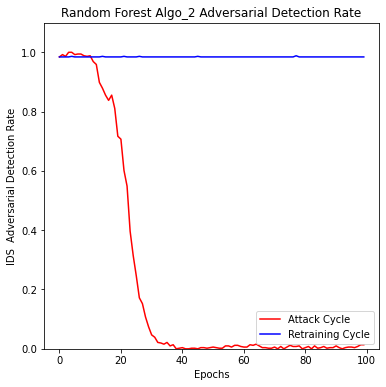

In [160]:
plt.figure(figsize=(6,6))
plt.plot(epochs, df_RF_2['ADR_attack'],color = 'r',label = 'Attack Cycle')
plt.plot(epochs, df_RF_2['ADR_retrained'],color = 'b',label = 'Retraining Cycle')
# plt.plot(epochs, ad_dr_after_training,color = 'b',label = 'Retraining Cycle',)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("IDS  Adversarial Detection Rate")
plt.ylim((0,1.1))
# plt.title("Original and Polymorphic Adversarial Detection")
plt.title("Random Forest Algo_2 Adversarial Detection Rate")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

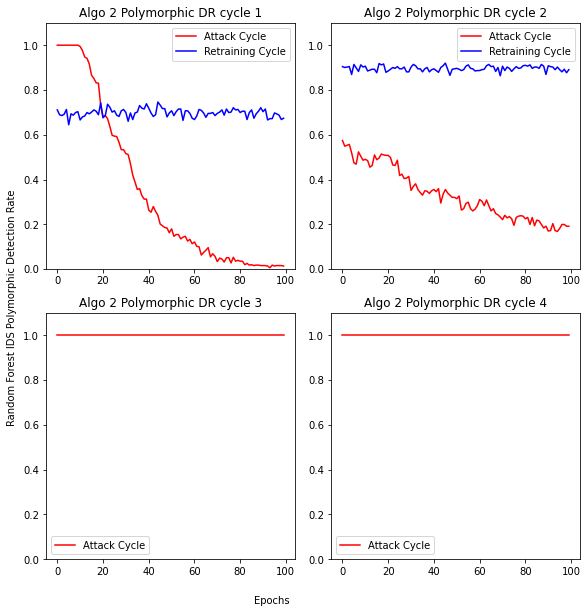

In [161]:
# Placing the plots in the plane
fig = plt.figure(figsize=(12,12))


plot1 = plt.subplot2grid((3, 3), (0, 0),rowspan=1,colspan=1)
plot2 = plt.subplot2grid((3, 3), (0, 1),rowspan=1,colspan=1)
plot3 = plt.subplot2grid((3, 3), (1, 0),rowspan=1,colspan=1)
plot4 = plt.subplot2grid((3, 3), (1, 1),rowspan=1,colspan=1)


# Plot for PDAR 1
plot1.plot(epochs, df_RF_2['PADR_attack_1'], color='r')
plot1.plot(epochs, df_RF_2['PADR_retrained_1'], color='b')
plot1.set_title('Algo 2 Polymorphic DR cycle 1')
plot1.set_ylim((0,1.1))
plot1.legend(labels=['Attack Cycle', 'Retraining Cycle'])


# Plot for PDAR 2
plot2.plot(epochs, df_RF_2['PADR_attack_2'], color='r')
plot2.plot(epochs, df_RF_2['PADR_retrained_2'], color='b')
plot2.set_title('Algo 2 Polymorphic DR cycle 2')
plot2.set_ylim((0,1.1))
plot2.legend(labels=['Attack Cycle', 'Retraining Cycle'])

# Plot for PDAR 3
plot3.plot(epochs, df_RF_2['PADR_attack_3'], color='r')
# plot3.plot(epochs, df_RF_2['PADR_retrained_3'], color='b')
plot3.set_title('Algo 2 Polymorphic DR cycle 3')
plot3.set_ylim((0,1.1))
plot3.legend(labels=['Attack Cycle', 'Retraining Cycle'])


# Plot for PDAR 3
plot4.plot(epochs, df_RF_2['PADR_attack_4'], color='r')
plot4.set_title('Algo 2 Polymorphic DR cycle 4')
plot4.set_ylim((0,1.1))
plot4.legend(labels=['Attack Cycle', 'Retraining Cycle'])

fig.text(0.3,0.3,'Epochs',ha = 'center',va = 'center')
fig.text(0.00005,0.64,'Random Forest IDS Polymorphic Detection Rate',ha = 'center',va = 'center',rotation = 'vertical')

  
# Packing all the plots and displaying them
plt.tight_layout()




Text(0, 0.5, 'Random Forest Algo_2 Overall IDS Detection Rate')

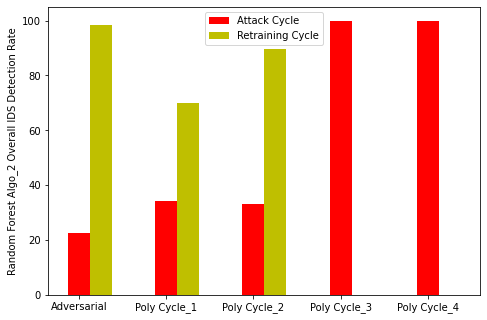

In [162]:
cycles = ['Adversarial','Poly Cycle_1', 'Poly Cycle_2', 'Poly Cycle_3', 'Poly Cycle_4']
total_DR_Attack = [df_RF_2['ADR_attack'].sum(),df_RF_2['PADR_attack_1'].sum(),df_RF_2['PADR_attack_2'].sum(),df_RF_2['PADR_attack_3'].sum(),df_RF_2['PADR_attack_4'].sum()
            ]
total_DR_Retrained = [df_RF_2['ADR_retrained'].sum(),df_RF_2['PADR_retrained_1'].sum(),df_RF_2['PADR_retrained_2'].sum(),0,0
            ]

X = np.arange(5)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cycles, total_DR_Attack, color = 'r', width = 0.25,label = 'Attack Cycle')
ax.bar(X + 0.25, total_DR_Retrained, color = 'y', width = 0.25)
ax.legend(labels=['Attack Cycle', 'Retraining Cycle'])
ax.set_ylabel('Random Forest Algo_2 Overall IDS Detection Rate')

Text(0.5, 1.0, 'Random Forest Algo_2 EIR')

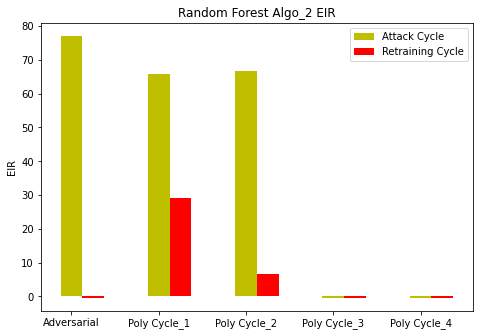

In [165]:
cycles = ['Adversarial','Poly Cycle_1', 'Poly Cycle_2', 'Poly Cycle_3', 'Poly Cycle_4']
total_EIR_Attack = [df_RF_2['AD_EIR_attack'].sum(),df_RF_2['EIR_attack_1'].sum(),df_RF_2['EIR_attack_2'].sum(),df_RF_2['EIR_attack_3'].sum(),df_RF_2['EIR_attack_4'].sum()
            ]
total_EIR_Retrained = [df_RF_2['AD_EIR_retrained'].sum(),df_RF_2['EIR_retrained_1'].sum(),df_RF_2['EIR_retrained_2'].sum(),df_RF_2['EIR_attack_3'].sum(),df_RF_2['EIR_attack_4'].sum()
            ]

X = np.arange(5)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cycles, total_EIR_Attack, color = 'y', width = 0.25,label = 'Attack Cycle')
ax.bar(X + 0.25, total_EIR_Retrained, color = 'r', width = 0.25)
ax.legend(labels=['Attack Cycle', 'Retraining Cycle'])
ax.set_ylabel('EIR')
ax.set_title('Random Forest Algo_2 EIR')

Text(0.5, 1.0, 'Random Forest Algo_2 F1 Score,Recall and TNR')

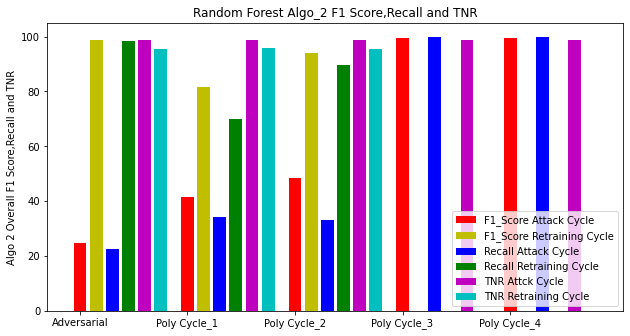

In [168]:
cycles = ['Adversarial','Poly Cycle_1', 'Poly Cycle_2', 'Poly Cycle_3', 'Poly Cycle_4']
total_F1_Attack = [df_RF_2['a_f1'].sum(),df_RF_2['p_attack_5_a_f1'].sum(),df_RF_2['p_attack_10_a_f1'].sum(),df_RF_2['p_attack_15_a_f1'].sum(),
                   df_RF_2['p_attack_20_a_f1'].sum()
            ]
total_F1_Retrained = [df_RF_2['a_f1_retrained'].sum(),df_RF_2['p_retrained_5_a_f1'].sum(),
                      df_RF_2['p_retrained_10_a_f1'].sum(),0,0
                      
            ]

total_Recall_Attack = [df_RF_2['a_recall'].sum(),df_RF_2['p_attack_5_a_recall'].sum(),df_RF_2['p_attack_10_a_recall'].sum(),
                       df_RF_2['p_attack_15_a_recall'].sum(),df_RF_2['p_attack_20_a_recall'].sum()
            ]
total_Recall_Retrained = [df_RF_2['a_recall_retrained'].sum(),df_RF_2['p_retrained_5_a_recall'].sum(),
                          df_RF_2['p_retrained_10_a_recall'].sum(),0,0
                          
            ]
TNR_Attack = [df_RF_2['a_tnr'].mean(),df_RF_2['p_attack_5_tnr'].mean(),df_RF_2['p_attack_10_tnr'].mean(),
              df_RF_2['p_attack_15_tnr'].mean(),df_RF_2['p_attack_20_tnr'].mean()
            ]
TNR_Retrained = [df_RF_2['a_tnr_retrained'].mean(),df_RF_2['p_retrained_5_tnr'].mean(),
                 df_RF_2['p_retrained_10_tnr'].mean(),0,0
            ]



X = np.arange(5)
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cycles, total_F1_Attack, color = 'r', width = 0.12,label = 'Attack Cycle')
ax.bar(X + 0.15, total_F1_Retrained, color = 'y', width = 0.12)
ax.bar(X + 0.30, total_Recall_Attack, color = 'b', width = 0.12)
ax.bar(X + 0.45, total_Recall_Retrained, color = 'g', width = 0.12)
ax.bar(X + 0.60, TNR_Attack,  color = 'm',width = 0.12)
ax.bar(X + 0.75, TNR_Retrained,  color = 'c',width = 0.12)
ax.legend(labels=['F1_Score Attack Cycle', 'F1_Score Retraining Cycle','Recall Attack Cycle', 'Recall Retraining Cycle','TNR Attck Cycle','TNR Retraining Cycle'],loc=4)
ax.set_ylabel('Algo 2 Overall F1 Score,Recall and TNR')
ax.set_title('Random Forest Algo_2 F1 Score,Recall and TNR')